In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def eval_clf_model(clf, data, labels):
    predictions = clf.predict(data)
    cm = confusion_matrix(labels, predictions)
    pre, rec, fscore, _ = precision_recall_fscore_support(labels,predictions, average='macro')
    sns.heatmap(cm, annot=True)
    print("Accuracy: ", accuracy_score(labels, predictions))
    print("Precision: ",pre)
    print("Recall: ", rec)
    print("FScore: ", fscore)

# Reading Data

In [2]:
#Reading the training data
df_train = pd.read_csv("HW1_data/ann-train.data",sep=' ',header=None)

df_train.drop(columns=df_train.columns[-2:],inplace=True)
df_train_data, df_train_labels = df_train.drop(columns=df_train.columns[-1:]), df_train[21]
#Reading the test data
df_test = pd.read_csv("HW1_data/ann-test.data",sep=' ',header=None)

df_test.drop(columns=df_test.columns[-2:],inplace=True)
df_test_data, df_test_labels = df_test.drop(columns=df_test.columns[-1:]), df_test[21]

#Normalizing datasets
df_train_data_n = df_train_data.copy()
df_test_data_n = df_test_data.copy()
for column in df_train_data.columns:
    if df_train_data[column].dtype == 'float64':
        mean = df_train_data[column].mean()
        std = df_train_data[column].std()
        
        df_train_data_n[column] = (df_train_data_n[column] - mean) / std
        df_test_data_n[column] = (df_test_data_n[column] - mean) / std

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df_train_data, df_train_labels, test_size=0.4, random_state=55)
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(df_train_data_n, df_train_labels, test_size=0.4, random_state=55)

# Building Raw Model

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
FScore:  1.0


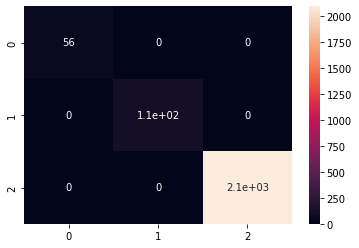

In [10]:
clf_raw = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')

clf_raw.fit(X_train,y_train)
eval_clf_model(clf_raw, X_train, y_train)

Accuracy:  0.9960238568588469
Precision:  0.9906067552833226
Recall:  0.9634860667118731
FScore:  0.9759625443006531


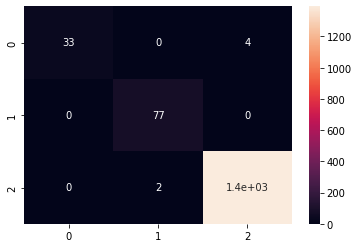

In [11]:
eval_clf_model(clf_raw, X_val, y_val)

Accuracy:  0.9924154025670945
Precision:  0.9450293396730286
Recall:  0.9705049843243073
FScore:  0.9573475431399379


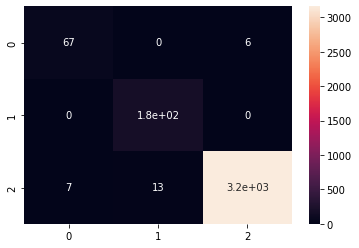

In [12]:
eval_clf_model(clf_raw, df_test_data, df_test_labels)

[Text(0.45454545454545453, 0.9285714285714286, 'X[16] <= 0.006\ngini = 0.141\nsamples = 2263\nvalue = [56, 114, 2093]'),
 Text(0.36363636363636365, 0.7857142857142857, 'gini = 0.0\nsamples = 2042\nvalue = [0, 0, 2042]'),
 Text(0.5454545454545454, 0.7857142857142857, 'X[20] <= 0.064\ngini = 0.616\nsamples = 221\nvalue = [56, 114, 51]'),
 Text(0.2727272727272727, 0.6428571428571429, 'X[7] <= 0.5\ngini = 0.124\nsamples = 60\nvalue = [56, 0, 4]'),
 Text(0.18181818181818182, 0.5, 'X[17] <= 0.024\ngini = 0.067\nsamples = 58\nvalue = [56, 0, 2]'),
 Text(0.09090909090909091, 0.35714285714285715, 'gini = 0.0\nsamples = 55\nvalue = [55, 0, 0]'),
 Text(0.2727272727272727, 0.35714285714285715, 'X[2] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2]'),
 Text(0.18181818181818182, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.36363636363636365, 0.21428571428571427, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.36363636363636365, 0.5, 'gini = 0.0\nsamples = 2\

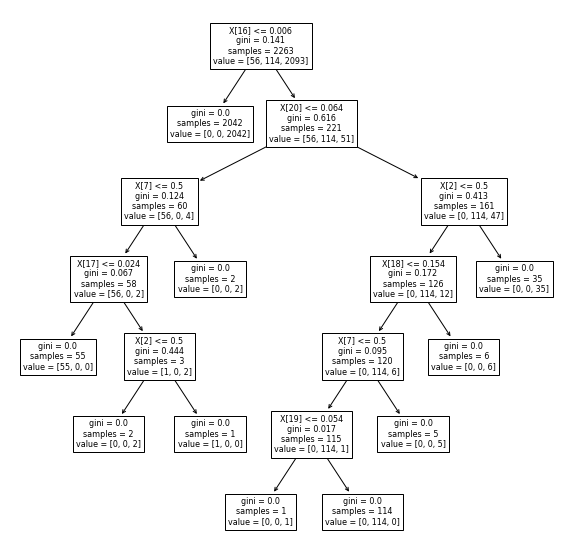

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]
tree.plot_tree(clf_raw)

# Pruning

In [14]:
clf_post_prune = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best',max_features=None)

path = clf_post_prune.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [15]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, criterion='gini',splitter='best',max_features=None)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08124854489507471


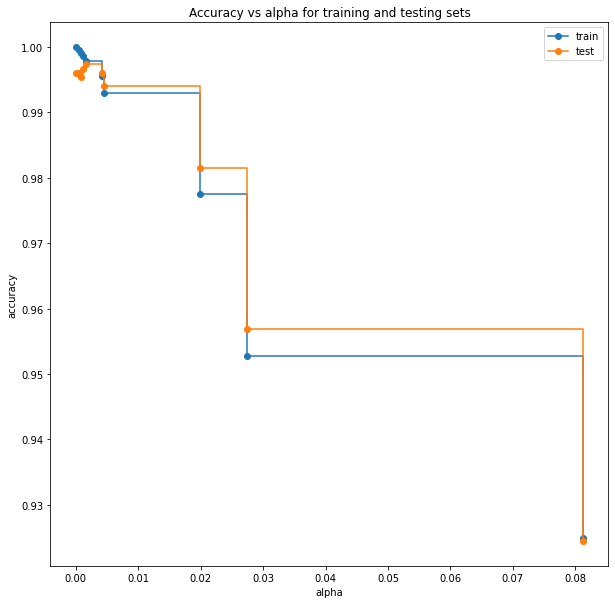

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [26]:
test_scores

[0.9960238568588469,
 0.9960238568588469,
 0.9953611663353215,
 0.9966865473823724,
 0.9973492379058979,
 0.9960238568588469,
 0.9940357852882704,
 0.9814446653412856,
 0.9569251159708416,
 0.9244532803180915]

Accuracy:  0.9929988331388565
Precision:  0.9335421888053467
Recall:  0.9974826935179358
FScore:  0.9635745635906998


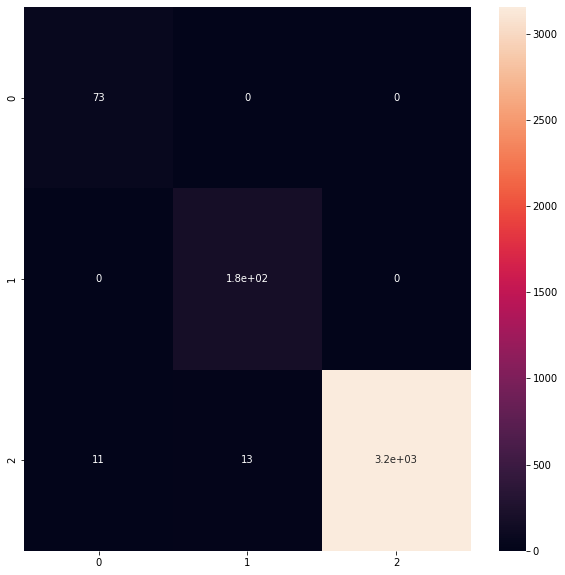

In [27]:
eval_clf_model(clfs[4], df_test_data, df_test_labels)

[Text(0.3333333333333333, 0.9166666666666666, 'X[16] <= 0.006\ngini = 0.141\nsamples = 2263\nvalue = [56, 114, 2093]'),
 Text(0.16666666666666666, 0.75, 'gini = 0.0\nsamples = 2042\nvalue = [0, 0, 2042]'),
 Text(0.5, 0.75, 'X[20] <= 0.064\ngini = 0.616\nsamples = 221\nvalue = [56, 114, 51]'),
 Text(0.3333333333333333, 0.5833333333333334, 'gini = 0.124\nsamples = 60\nvalue = [56, 0, 4]'),
 Text(0.6666666666666666, 0.5833333333333334, 'X[2] <= 0.5\ngini = 0.413\nsamples = 161\nvalue = [0, 114, 47]'),
 Text(0.5, 0.4166666666666667, 'X[18] <= 0.154\ngini = 0.172\nsamples = 126\nvalue = [0, 114, 12]'),
 Text(0.3333333333333333, 0.25, 'X[7] <= 0.5\ngini = 0.095\nsamples = 120\nvalue = [0, 114, 6]'),
 Text(0.16666666666666666, 0.08333333333333333, 'gini = 0.017\nsamples = 115\nvalue = [0, 114, 1]'),
 Text(0.5, 0.08333333333333333, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 5]'),
 Text(0.6666666666666666, 0.25, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 6]'),
 Text(0.8333333333333334, 0.4166666666

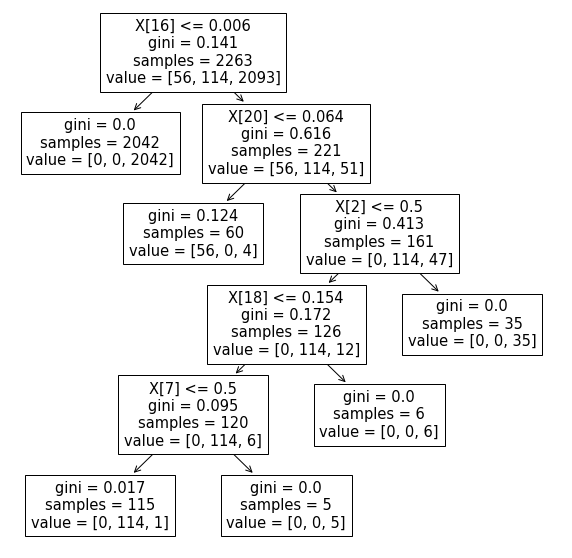

In [28]:
plt.rcParams['figure.figsize'] = [10, 10]
tree.plot_tree(clfs[4])

# Building With Normalized Data

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
FScore:  1.0


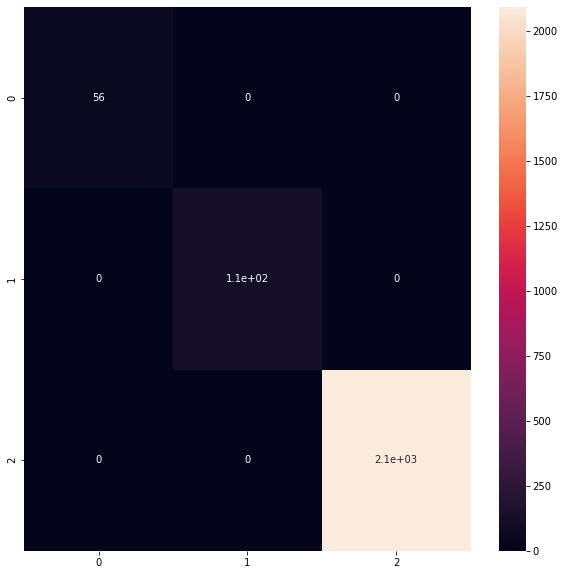

In [29]:
clf_raw_n = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best',max_features=None)

clf_raw_n.fit(X_train_n,y_train_n)
eval_clf_model(clf_raw_n, X_train_n, y_train_n)

Accuracy:  0.9924154025670945
Precision:  0.9450293396730286
Recall:  0.9705049843243073
FScore:  0.9573475431399379


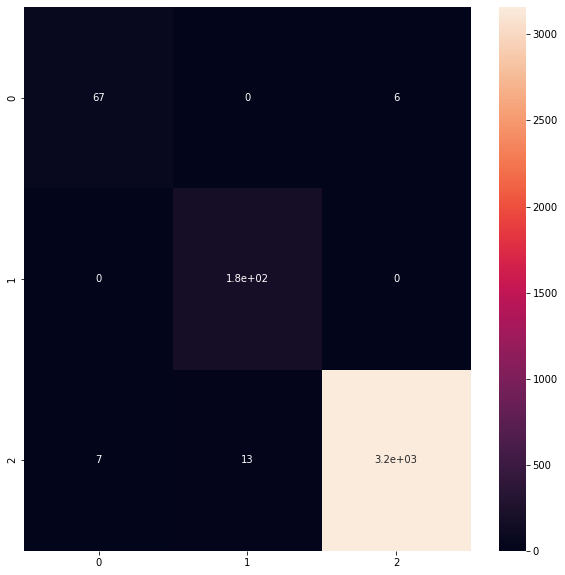

In [30]:
eval_clf_model(clf_raw_n, df_test_data_n, df_test_labels)

# Model With Balanced Dataset

In [31]:
for i in df_train[21].unique():
    print(i, " : " ,df_train[df_train[21] == i].count().unique())

3  :  [3488]
2  :  [191]
1  :  [93]


In [32]:
#df_oversample = pd.concat([df_train[df_train[21] == 1], df_train[df_train[21] == 1]])
df_train_b = pd.concat([df_train[df_train[21] == 3].sample(n=191), df_train[df_train[21] != 3]])#, df_oversample])

In [33]:
for i in df_train_b[21].unique():
    print(i, " : " ,df_train_b[df_train[21] == i].count().unique())

3  :  [191]
2  :  [191]
1  :  [93]


C:\Users\TR\AppData\Local\Temp/ipykernel_23828/779148980.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(i, " : " ,df_train_b[df_train[21] == i].count().unique())


In [34]:
df_train_data_b, df_train_labels_b = df_train_b.drop(columns=df_train_b.columns[-1:]), df_train_b[21]

In [35]:
df_train_labels_b

2517    3
3130    3
1458    3
1034    3
1552    3
       ..
3728    2
3732    2
3754    2
3755    2
3769    2
Name: 21, Length: 475, dtype: int64

Accuracy:  0.9880396732788798
Precision:  0.9080400276052449
Recall:  0.9956996014264736
FScore:  0.9484396091686796


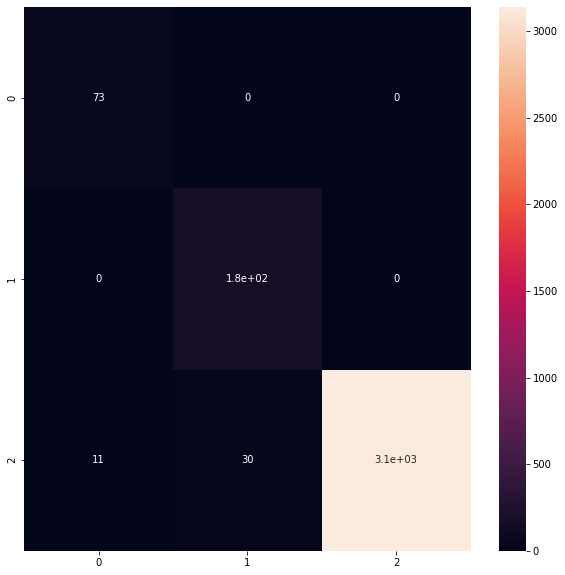

In [36]:
clf_raw_b = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best',max_features=None)

clf_raw_b.fit(df_train_data_b,df_train_labels_b)
eval_clf_model(clf_raw_b, df_test_data, df_test_labels)